# Extract All Topics From A Given Tweet

In [0]:
import re
import pickle
import numpy as np
import nltk
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.svm import LinearSVC
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import f1_score,precision_score,recall_score, jaccard_score

# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

# 1) Load data and Combine tweets per user



```
pkl_file = open('/content/gdrive/My Drive/Datasets/TwitterData/' + fileName[0], 'rb')
getDict = pickle.load(pkl_file)
getDict

pkl_file = open('/content/gdrive/My Drive/Datasets/TwitterData/' + fileName[0], 'rb')
getDict = pickle.load(pkl_file)
contentData = []
for user in getDict:
  A = getCombineTweetsPerUser(getDict[user])
  contentData.append(A)
print(contentData) 
```



In [0]:
fileName = ['electronics_train_data.data', 'politics_train_data.data', 'travel_train_data.data', 'car_train_data.data',
            'electronics_and_car_train_data.data', 'politics_and_car_train_data.data', 'travel_and_car_train_data.data', 
						'politics_and_travel_train_data.data', 'travel_and_electronics_train_data.data']

labelsFile = [['electronics'], ['politics'], ['travel'], ['car'],
              ['electronics','car'], ['politics','car'], ['travel','car'],
							['politics','travel'], ['travel','electronics']]

def getCombineTweetsPerUser(tweetList):
	result = ''
	for tweet in tweetList:
		result = result + ' '
		result = result + tweet
	return result

def readPickleFiles():
  labelData = []
  contentData = []
  for index in range(len(fileName)):
    pkl_file = open('/content/gdrive/My Drive/Datasets/TwitterData/' + fileName[index],'rb')
    getDict = pickle.load(pkl_file)
    for user in getDict:
      aggregatedDoc = getCombineTweetsPerUser(getDict[user])
      contentData.append(aggregatedDoc)
      labelData.append(labelsFile[index])
  return labelData,contentData

label, Content = readPickleFiles()
trainContent, testContent, labelTrain, labelTest = train_test_split(Content, label, test_size=.2, random_state=1)

# 2 ) Clean data, Remove stopwords, Tokenize & Vectorize

Text preprocessing is an important step for natural language processing tasks. These steps are needed for converting text from human language to machine-readable format for further processing. We perform the following preprocessing steps: convert text to lower case, tokenize words, remove stopwords, remove unwanted punctuation (remove words except those containing [a-zA-Z]).

Tokenization is a process to extract terms from the corpus and place them into
a list of strings. The *tokenizer* argument passed to the *TfidfVectorizer()* should be a function that takes a string as an input. In natural language processing, useless words, are referred to as stop words. A stop word is a commonly used word and these include pronouns and articles such as a, the, etc. In text analysis, it is common practice to extract and discard these words. This reduces the pool of terms in the semi-structured data and improves the extraction of topics and information. We wish to use regular expressions to remove words containing unwanted punctuations. *re.compile(pattern)* compiles a regular expression pattern into a regular expression object, which can be used for matching using its *match()* method.


In [0]:
nltk.download('stopwords')
nltk.download('punkt')
stopWords = stopwords.words('english')

def getOnlyWords(wordsList):
	pattern = re.compile('[a-zA-Z]+')
	result = []
	for word in wordsList:
		if pattern.match(word) != None:
		  result.append(word)
	return result

def getWordsWithoutStop(sentence):
	sentence = sentence.lower()
	words = word_tokenize(sentence)
	withoutStopWords = [word for word in words if not word in stopWords]
	return getOnlyWords(withoutStopWords)
 
vectorizer = TfidfVectorizer(tokenizer = getWordsWithoutStop)
vectorizedTrainData = vectorizer.fit_transform(trainContent)
vectorizedTestData = vectorizer.transform(testContent)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 3) Problem Transformation


Multiclass classification means a classification task with more than two classes; e.g., classify a set of images of fruits which may be oranges, apples, or pears. Multilabel classification assigns to each sample a set of target labels. A text might be about any of religion, politics, finance or education at the same time or none of these.

Multilabelbinarizer allows you to encode multiple labels per instance. 

Classifier Chain - A chain C1, · · · , C|L| of binary classifiers is formed. Each classifier Cj
in the chain is responsible for learning and predicting the binary association of label
lj given the feature space, augmented by all prior binary relevance predictions
in the chain l1, · · · , lj−1. The classification process begins at C1 and propagates
along the chain: C1 determines Pr(l1|x) and every following classifier C2 · · · C|L|
predicts P r(lj |xi, l1, . . . , lj−1). 


In [0]:
multiLabelBinary = MultiLabelBinarizer()
trainBinaryLabel = multiLabelBinary.fit_transform(labelTrain)
testBinaryLabel = multiLabelBinary.transform(labelTest)

# 4) Baseline Linear SVM

In the multilabel learning literature, Binary Relevance method can be implemented using OneVsRestClassifier.



In [0]:
classifierSVM = OneVsRestClassifier(LinearSVC())
classifierSVM.fit(vectorizedTrainData, trainBinaryLabel)
predictionsTrain = classifierSVM.predict(vectorizedTrainData)

precisionTrain = precision_score(trainBinaryLabel, predictionsTrain, average = 'micro')
print ("Linear SVM multi-label Train micro,")
print (precisionTrain)

precisionTrain = precision_score(trainBinaryLabel, predictionsTrain, average = 'macro')
print ("Linear SVM multi-label Train macro,")
print (precisionTrain)

predictionsTest = classifierSVM.predict(vectorizedTestData)

precisionTest = precision_score(testBinaryLabel, predictionsTest, average = 'micro')
print ("Linear SVM multi-label Test micro,")
print (precisionTest)

precisionTest = precision_score(testBinaryLabel, predictionsTest, average = 'macro')
print ("Linear SVM multi-label Test macro,")
print (precisionTest)


Linear SVM multi-label Train micro,
0.9982319405354695
Linear SVM multi-label Train macro,
0.9983372343789407
Linear SVM multi-label Test micro,
0.978283818428593
Linear SVM multi-label Test macro,
0.9788741467265407


# 5) Ensemble of Classifier Chains

In this method, we create 20 classifier chains. Each classifier chain contains a linear support vector model for each of the 4 labels. The models in each chain are ordered randomly. In addition to the features in the dataset, each model gets the predictions of the preceding models in the chain as features. These additional features allow each chain to exploit correlations among the classes. 

Because the models in each chain are arranged randomly there is significant variation in performance among the chains. Presumably there is an optimal ordering of the classes in a chain that will yield the best performance. However we do not know that ordering a priori. Instead we can construct a voting ensemble of classifier chains by averaging the binary predictions of the chains on the train set and find the optimal threshold value. 


In [0]:
# Fit an ensemble of Linear SVM classifier chains and take the average prediction of all the chains
chains = [ClassifierChain(LinearSVC(), order='random', random_state=i)
          for i in range(20)]
for chain in chains:
  chain.fit(vectorizedTrainData,trainBinaryLabel)

# Make predictions on train data
pred_train_chains = np.array([chain.predict(vectorizedTrainData) 
                             for chain in chains])

# Find the optimal threshold value which maximizes the train precision score 
# To achieve this, we average the binary predictions of the chains, then iterate on different threshold values
pred_train_ensemble = pred_train_chains.mean(axis=0)
threshold = [0.1, 0.2, 0.3, 0.4, 0.5]
optimal_threshold = 0.0
max_precision = 0.0

for thres in threshold:
  curPredictionsTrain = (pred_train_ensemble >= thres)
  precisionTrain = precision_score(trainBinaryLabel, curPredictionsTrain, average = 'micro')
  precisionTrain = precision_score(trainBinaryLabel, curPredictionsTrain, average = 'macro')
  if max_precision < precisionTrain:
    max_precision = precisionTrain
    optimal_threshold = thres

# Make predictions on test data using the optimal threshold value found above
pred_test_chains = np.array([chain.predict(vectorizedTestData) 
                             for chain in chains])
pred_test_ensemble = pred_test_chains.mean(axis=0)
pred_test_ensemble = (pred_test_ensemble >= optimal_threshold)

# Calculate Jaccard scores
chain_jaccard_scores = [jaccard_score(testBinaryLabel, pred_test_chain, average='micro') 
                        for pred_test_chain in pred_test_chains]
ensemble_jaccard_score = jaccard_score(testBinaryLabel, pred_test_ensemble, average='micro')
model_scores = chain_jaccard_scores + [ensemble_jaccard_score]

# Test results using ensmeble CC 
precisionTest = precision_score(testBinaryLabel, pred_test_ensemble, average = 'micro')
print ("ClassifierChain multi-label Test micro,")
print (precisionTest)

precisionTest = precision_score(testBinaryLabel, pred_test_ensemble, average = 'macro')
print ("ClassifierChain multi-label Test macro,")
print (precisionTest)

ClassifierChain multi-label Test micro,
0.9710510688836105
ClassifierChain multi-label Test macro,
0.9717348327959124


# 5) Plot Jaccard Similarity

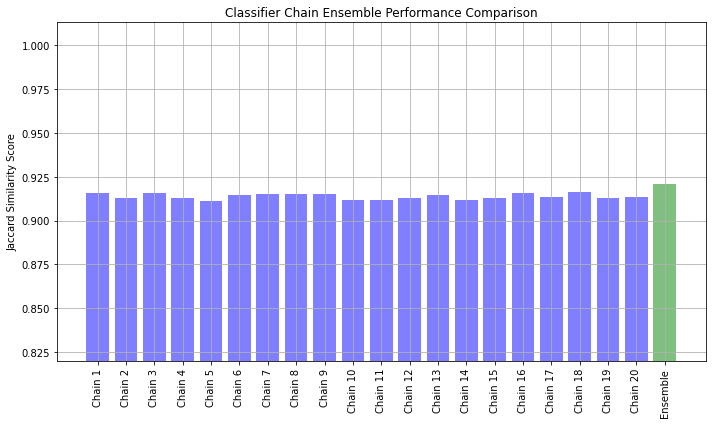

In [0]:
# Plot the Jaccard similarity scores for the independent model, each of the chains, and the ensemble 
model_names = ('Chain 1', 'Chain 2', 'Chain 3', 'Chain 4', 'Chain 5', 'Chain 6', 'Chain 7', 'Chain 8', 'Chain 9', 'Chain 10',
               'Chain 11', 'Chain 12', 'Chain 13', 'Chain 14', 'Chain 15', 'Chain 16', 'Chain 17', 'Chain 18', 'Chain 19',
               'Chain 20', 'Ensemble')
x_pos = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
colors = ['b'] * len(chain_jaccard_scores) + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()